This notebook tries to replicate what is done [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb)  but in Pytorch.

Reference: [Distill.pub / Differentiable Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


import torch

from torchvision import models

import numpy as np

import PIL.Image
import urllib

import matplotlib.pyplot as plt

from pyimgy.optional.torch import *
from netlens.style_transfer import *
from netlens.modules import Normalization


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 7981694976
Free memory: 7971209216
Used memory: 10485760


In [5]:
torch.cuda.memory_allocated()

0

In [6]:
model = models.googlenet(pretrained=True).cuda()

In [7]:
def load(url):
    img = PIL.Image.open(urllib.request.urlopen(url))
    return np.array(img)

(512, 512, 3) (512, 645, 3)


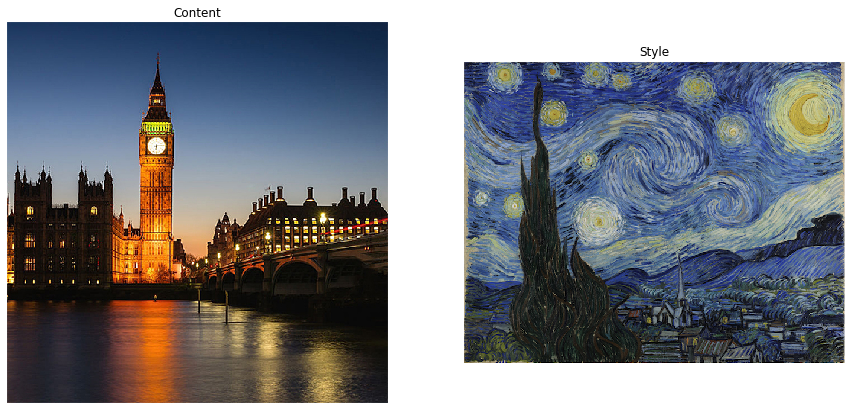

In [8]:
# how to load images from URLs?

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show_images([content_image, style_image], ['Content', 'Style'])

In [9]:
type(content_image)

numpy.ndarray

In [10]:
import torchvision.transforms as T

def transform_inputs(content_image, style_image):
    content_tfms = T.ToTensor()
    content_input = content_tfms(content_image).unsqueeze(0)
    # content_input = norm(content_tfms(content_image), input_range=(0, 1), grad=False)
    style_tfms = T.Compose([T.ToPILImage(), T.RandomCrop(content_image.shape[:2]), T.ToTensor()])
    style_input = style_tfms(style_image).unsqueeze(0)
    # style_input = norm(style_tfms(style_image), input_range=(0, 1), grad=False)
    return content_input, style_input

In [11]:
content_input, style_input = transform_inputs(content_image, style_image)

In [12]:
content_input = content_input.cuda()
style_input = style_input.cuda()

In [13]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [15]:
arch = FlatModel.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

In [16]:
arch

FlatModel(
  (layers): ModuleDict(
    (normalization-0): Normalization()
    (conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-0): ReLU()
    (conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-1): ReLU()
    (pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-2): ReLU()
    (conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-3): ReLU()
    (pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-4): ReLU()
    (conv-5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-5): ReLU()
    (conv-6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-6): ReLU()
    (conv-7): Conv2d(256, 256, ke

In [17]:
style_injects = [f'conv-{i}' for i in range(5)]
content_injects = ['conv-3']

In [18]:
show_images([content_input, style_input])

In [19]:
style_module = StyleTransferModule(arch, content_input, content_injects, style_input, style_injects)

In [20]:
style_module

StyleTransferModule(
  (layers): ModuleDict(
    (normalization-0): Normalization()
    (conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-0): FeatureLoss()
    (relu-0): ReLU()
    (conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-1): FeatureLoss()
    (relu-1): ReLU()
    (pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-2): FeatureLoss()
    (relu-2): ReLU()
    (conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-3): FeatureLoss()
    (content_loss-3): FeatureLoss()
    (relu-3): ReLU()
    (pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-4): FeatureLoss()
  )
)

In [21]:
len(style_module.layers)

18

In [22]:
[m.target.sum() for k, m in style_module.layers.items() if k.startswith('style_loss')]

[tensor(1.0034, device='cuda:0'),
 tensor(32.3343, device='cuda:0'),
 tensor(423.8353, device='cuda:0'),
 tensor(729.2153, device='cuda:0'),
 tensor(2811.5674, device='cuda:0')]

In [23]:
[m.target.sum() for k, m in style_module.layers.items() if k.startswith('content_loss')]

[tensor(-12774281., device='cuda:0')]

In [24]:
class STCallback(OptVisCallback):
    def on_step_end(self, optvis, img, *args, **kwargs):
        if optvis.is_step_to_show():
            print(f'Style loss={optvis.objective.style_loss}, Content loss={optvis.objective.content_loss}, TV loss={optvis.objective.tv_loss}')

In [25]:
style_obj = StyleTransferObjective(style_module, style_weight=100000, content_weight=1, tv_weight=0)

In [26]:
import torch.optim
from netlens.visualization.render import *

optvis = OptVis(style_module, style_obj, optim=optim.LBFGS)

In [27]:
content_input.shape

torch.Size([1, 3, 512, 512])

In [28]:
# we need to pre-prend the "layer" of the parameterization
from netlens.visualization import param

image_param = param.ImageParam(im_initial=content_input, fft=True, decorrelate=True)

Run [50], loss=244.3818
Style loss=214.2930908203125, Content loss=30.088720321655273, TV loss=0.0
Run [100], loss=58.0306
Style loss=28.380084991455078, Content loss=29.650487899780273, TV loss=0.0
Run [150], loss=33.5445
Style loss=8.061397552490234, Content loss=25.483068466186523, TV loss=0.0
Run [200], loss=24.6601


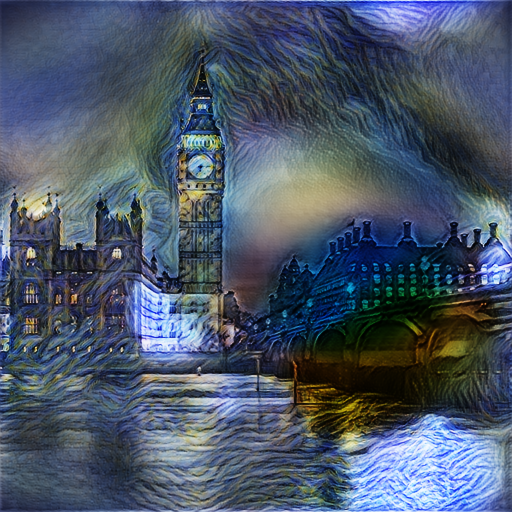

Style loss=3.6373984813690186, Content loss=21.02269172668457, TV loss=0.0
Run [250], loss=20.1413
Style loss=2.412982225418091, Content loss=17.72834014892578, TV loss=0.0
Run [300], loss=17.1679
Style loss=1.885836124420166, Content loss=15.282098770141602, TV loss=0.0
Run [350], loss=15.4106
Style loss=1.5906989574432373, Content loss=13.81991958618164, TV loss=0.0
Run [400], loss=14.1355


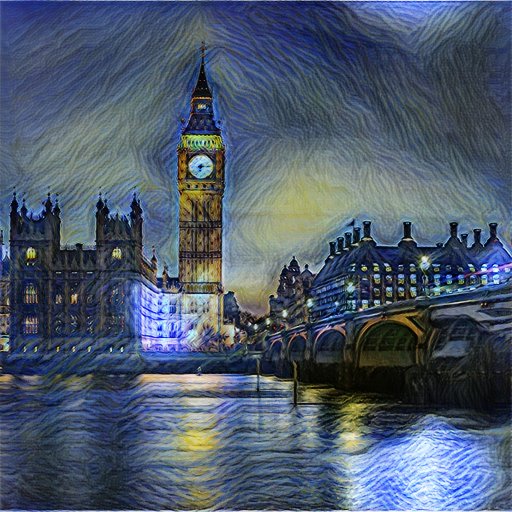

Style loss=1.372438669204712, Content loss=12.763053894042969, TV loss=0.0
Run [450], loss=13.3125
Style loss=1.3013559579849243, Content loss=12.011164665222168, TV loss=0.0
Run [500], loss=12.7310
Style loss=1.2413451671600342, Content loss=11.489675521850586, TV loss=0.0
Run [550], loss=12.2890
Style loss=1.1921440362930298, Content loss=11.096820831298828, TV loss=0.0
Run [600], loss=11.9509


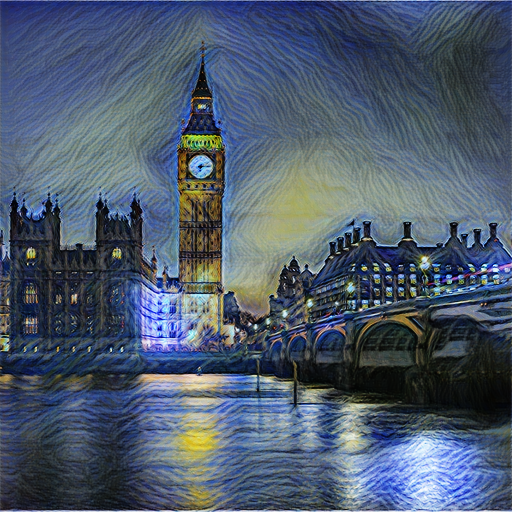

Style loss=1.1780914068222046, Content loss=10.772806167602539, TV loss=0.0
Run [650], loss=11.7066
Style loss=1.1427552700042725, Content loss=10.563807487487793, TV loss=0.0
Run [700], loss=11.4671
Style loss=1.1204795837402344, Content loss=10.346633911132812, TV loss=0.0
Run [750], loss=11.2903
Style loss=1.1052109003067017, Content loss=10.185089111328125, TV loss=0.0
Run [800], loss=11.1494


Style loss=1.0919216871261597, Content loss=10.057454109191895, TV loss=0.0
Run [850], loss=11.0150
Style loss=1.0864417552947998, Content loss=9.928553581237793, TV loss=0.0
Run [900], loss=10.9082
Style loss=1.0811688899993896, Content loss=9.827031135559082, TV loss=0.0
Run [950], loss=10.8165
Style loss=1.0679664611816406, Content loss=9.74858283996582, TV loss=0.0
Run [1000], loss=10.7325


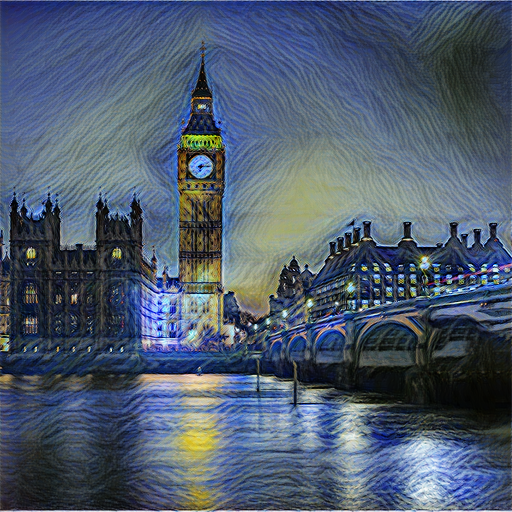

Style loss=1.062788486480713, Content loss=9.669707298278809, TV loss=0.0
Run [1050], loss=10.6634
Style loss=1.0574365854263306, Content loss=9.605937957763672, TV loss=0.0
Run [1100], loss=10.5998
Style loss=1.05290687084198, Content loss=9.546918869018555, TV loss=0.0
Run [1150], loss=10.5426
Style loss=1.0491573810577393, Content loss=9.493441581726074, TV loss=0.0
Run [1200], loss=10.4944


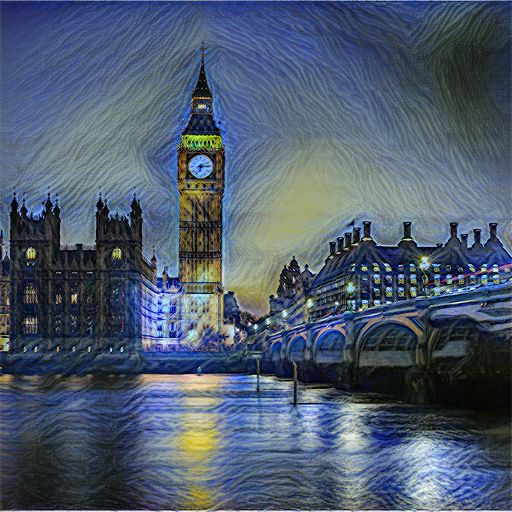

Style loss=1.0478367805480957, Content loss=9.446576118469238, TV loss=0.0


In [29]:
output = optvis.vis(image_param, thresh=(200,400,600,800,1000,1200), transform=False, in_closure=True, show=True, callback=STCallback())

In [30]:
#trials = [10000, 140000, 160000]

In [31]:
output = image_param()

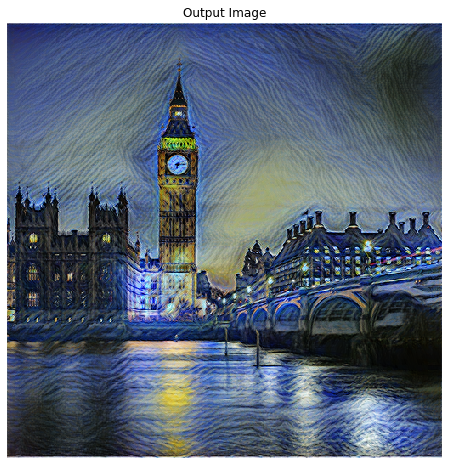

In [32]:
show_images([output], ['Output Image'])